В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [47]:
#!conda install -c conda-forge xgboost -y

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score

def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
raw_df = pd.read_csv("https://docs.google.com/spreadsheets/d/11uG3Rk3uaw-RLfTY-dkWST3EdSvhpNQipIu6PylnWBM/gviz/tq?tqx=out:csv&sheet=Sheet1")

target_col='Exited'
input_cols = [col for col in raw_df.columns if col not in [target_col, 'id', 'Surname', 'CustomerId']]

train_df, val_df = split_train_val(raw_df, target_col=target_col)
X_train, y_train = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target_col)
X_val, y_val = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [4]:
cat_features = X_train.select_dtypes(include=['object']).columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [20]:
xgd_clf = XGBClassifier(
    n_estimators=10,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=True,
    missing=np.nan
)
xgd_clf.fit(X_train, y_train)

train_roc_auc = xgd_clf.score(X_train, y_train)
val_roc_auc = xgd_clf.score(X_val, y_val)

print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Validation ROC AUC: {val_roc_auc:.4f}")


Train ROC AUC: 0.9008
Validation ROC AUC: 0.8933


Якість моделі `DecisionTreeClassifier` з оптимальними налаштуваннями гіперпараметрів:

Train AUROC with RandomizedSearchCV: `0.9169`

Validation AUROC with RandomizedSearchCV: `0.9166`

**Висновок:**

Нова модель `XGBoost` показала досить високий AUROC `90,08%` на тренувальних даних та `89,33%` на валідаційних даних. Це означає, що модель добре натренувалась і узагальнює дані. Порівнюючи з попередньою моделлю XGBoost показує гірші рузультати, проте варто зазначити що в даній моделі навмання вибрані параметри на вілміну від результатів порівнюваної моделі.
Тому потрібно спочатку підтюнити модель найкращими параметрами а потім робити висновки.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [44]:
def objective(params):
  model = XGBClassifier(
      n_estimators=int(params['n_estimators']),
      max_depth=int(params['max_depth']),
      learning_rate=params['learning_rate'],
      subsample=params['subsample'],
      colsample_bytree=params['colsample_bytree'],
      gamma=params['gamma'],
      reg_alpha=params['reg_alpha'],
      reg_lambda=params['reg_lambda'],
      random_state=42,
      enable_categorical=True,
      missing=np.nan,
      early_stopping_rounds=10
  )

  model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
  val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
  return {'loss': -val_roc_auc, 'status': STATUS_OK}


space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 10),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

final_clf = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    enable_categorical=True,
    missing=np.nan
)

final_clf.fit(X_train, y_train)
train_roc_auc_best = roc_auc_score(y_train, final_clf.predict_proba(X_train)[:, 1])
val_roc_auc_best = roc_auc_score(y_val, final_clf.predict_proba(X_val)[:, 1])

print(f"Train ROC AUC with best parameters: {train_roc_auc_best:.4f}")
print(f"Validation ROC AUC with best parameters: {val_roc_auc_best:.4f}")

100%|██████████| 100/100 [00:13<00:00,  7.63trial/s, best loss: -0.937944303450168]
Best parameters found:
n_estimators: 80
max_depth: 5
learning_rate: 0.06279744375830155
subsample: 0.5883438996488296
colsample_bytree: 0.7542454163685721
reg_alpha: 0.8469847603038194
reg_lambda: 0.31752250763764145
Train ROC AUC with best parameters: 0.9496
Validation ROC AUC with best parameters: 0.9371


**Висновок:**

Нова модель `XGBoost` з оптимальними гіперпараметрами знайденими за допомогою `Hyperopt` показала досить високий AUROC `94,96%` на тренувальних даних та `93,71%` на валідаційних даних. Це означає, що модель добре натренувалась і не досить точно узагальнює дані що може призвести до гірших результатів на нових даних. Порівнюючи з попередньою моделлю XGBoost показує кращі результати як на тренувальній так і на валідаційній вибірках

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [50]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]
lgb_clf = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    categorical_feature=cat_feature_indexes
)

lgb_clf.fit(X_train, y_train)

train_roc_auc_lgb = roc_auc_score(y_train, lgb_clf.predict_proba(X_train)[:, 1])
val_roc_auc_lgb = roc_auc_score(y_val, lgb_clf.predict_proba(X_val)[:, 1])

print(f"Train ROC AUC LGBM: {train_roc_auc_lgb:.4f}")
print(f"Validation ROC AUC LGBM: {val_roc_auc_lgb:.4f}")

[LightGBM] [Warning] categorical_feature is set=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\shyx8\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


**Висновок:**

Нова модель `LightGBM` з навмання обраними гіперпараметрами показала високий AUROC `96,80%` на тренувальних даних та `93,29%` на валідаційних даних. Це означає, що модель добре натренувалась і гірше узагальнює дані, тобто є ознаки перетренування. Тому спочатку потрібно знайти оптимальні гіперпараметри

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [55]:
def objective(params):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        cat_feature=cat_feature_indexes
    )

    model.fit(X_train, y_train)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    return {'loss': -val_roc_auc, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=60, trials=trials)

best_params_lgb = {
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain']
}

print("Best parameters found for LGBM:")
for param, value in best_params_lgb.items():
    print(f"{param}: {value}")

final_lgb_clf = LGBMClassifier(
    n_estimators=best_params_lgb['n_estimators'],
    learning_rate=best_params_lgb['learning_rate'],
    max_depth=best_params_lgb['max_depth'],
    num_leaves=best_params_lgb['num_leaves'],
    min_child_weight=best_params_lgb['min_child_weight'],
    subsample=best_params_lgb['subsample'],
    colsample_bytree=best_params_lgb['colsample_bytree'],
    reg_alpha=best_params_lgb['reg_alpha'],
    reg_lambda=best_params_lgb['reg_lambda'],
    min_split_gain=best_params_lgb['min_split_gain'],
    random_state=42,
    categorical_feature=cat_feature_indexes
)

final_lgb_clf.fit(X_train, y_train)
train_roc_auc_lgb_best = roc_auc_score(y_train, final_lgb_clf.predict_proba(X_train)[:, 1])
val_roc_auc_lgb_best = roc_auc_score(y_val, final_lgb_clf.predict_proba(X_val)[:, 1])

print(f"Train ROC AUC LGBM with best parameters: {train_roc_auc_lgb_best:.4f}")
print(f"Validation ROC AUC LGBM with best parameters: {val_roc_auc_lgb_best:.4f}")

[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558             
[LightGBM] [Info] Auto-choosin

c:\Users\shyx8\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


**Висновок:**

Нова модель `LightGBM` з оптимальними гіперпараметрами знайденими за допомогою `Hyperopt` показала високий AUROC `94,23%` на тренувальних даних та `93,69%` на валідаційних даних. Це означає, що модель добре натренувалась і добре узагальнює дані. В порівнянні з `XGBoost` з оптимальними гіперпараметрами знайденими за допомогою `Hyperopt` `94,96%` на тренувальних даних та `93,71%` на валідаційних даних можна сказати що обидві моделі показали майже однакові результати і можуть бути використані обидві.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [56]:
# create a submission file
test_raw_data = pd.read_csv("https://docs.google.com/spreadsheets/d/1oRLDSQ8Mlc0nq_mTS7ffBFWij7WMGu5lh1-5H5abBWc/gviz/tq?tqx=out:csv&sheet=Test")

test_inputs = test_raw_data[input_cols].copy()
test_inputs[cat_features] = test_inputs[cat_features].astype('category')

test_raw_data['Exited'] = final_lgb_clf.predict(test_inputs)

# Read sample_submission.csv file
sample_submission = pd.read_csv("https://docs.google.com/spreadsheets/d/1OuQDoTmdSp2jDaBEGLF3pOWXJvj0USSem35Elxxfg4M/gviz/tq?tqx=out:csv&sheet=SampleSubmission")
# Save the predictions to the sample_submission DataFrame by id without indexes
sample_submission['Exited'] = test_raw_data['Exited']
# Save csv file with predictions
sample_submission.to_csv("submission_lgb_clf_best.csv", index=False)

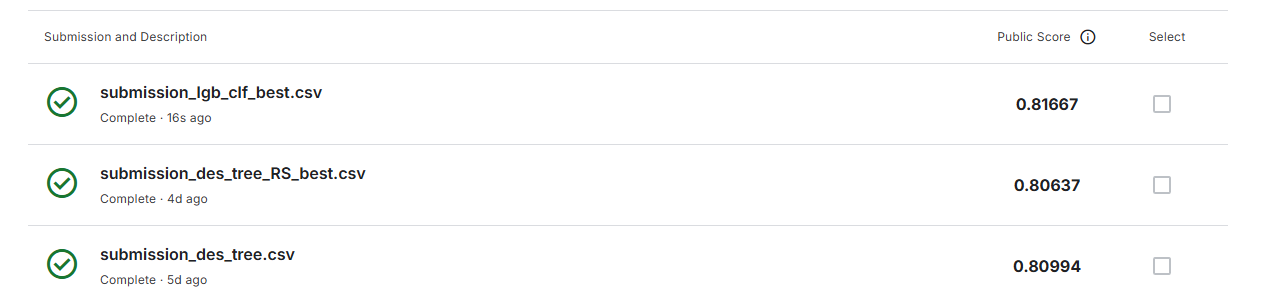